Student Name: Aryank Gupta

Student ID: 24101613

# Activity 6: Pytorch and CNNs for Fashion-MNIST

In this activity, we are going to explore designing various neural networks for the FashionMNIST classification problem. This is, of course, a 'toy' problem, but the fundamentals of classification of images is here.


## Hints, tips, and notes

* Here I'm not going to mandate TensorBoard. In Colab, this is a little bit more involved. Instead, we'll just put the losses and accuracies in a list and print them after training. However, TensorBoard is very useful, particularly for projects, so I suggest playing around with it.
* Some of these runs will take several minutes to complete. This is the nature of ML. Grab a beer, or a coffee.

As usual, we will give you some code that you use to build the rest of the activity.

# Common Code

All the imports

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from torchvision import models

### 1. Select the device to use.

To access the GPU on Google Colab, `Select Runtime` -> `Change Runtime Type` and pick `GPU` from the `Hardware Accelerator` dropdown menu. In the free version, the GPU is modest. If you buy credits, you get access to a much nice A100 GPU. In both cases, you may find contention for the resource is an issue, but less likely to happen if you use credits.

In [ ]:
# Get appropriate device for training
device = ( "cuda"     # CUDA is a programming interface for certain Nvidia GPUs
           if torch.cuda.is_available()
           else "mps"  # Kind of like CUDA for a mac, I guess? I don't use macs
           if torch.backends.mps.is_available()
           else "cpu" )   # If you end up with CPU, go use Google Colab and get a GPU

print(f"{device} device available")

cuda device available


### 2. Code for training the models

I'm going to provide this code, rather than you having to struggle creating it. This is a normal training cycle with PyTorch. However, I do want you to explain the PyTorch functions called in the train function. I will marke them with comments.

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()        #<--- what is this function for?

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)   #<--- this is a bit funny, explain it

        # Compute prediction error
        pred = model(X)                     #<--- what is this for?
        loss = loss_fn(pred, y)             #<--- what is this for?

        # This is the backprop set up. Explain what each of the steps do
        loss.backward()                     #<--- what is this for?
        optimizer.step()                    #<--- what is this for?
        optimizer.zero_grad()               #<--- what is this for?

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    accuracy /= size

    return loss, accuracy

def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # Iterate over each epoch
    for t in range(epochs):
        print(f"Epoch {t+1}:\n")
        train(train_dataloader, model, loss_fn, optimizer)

        # Get the overall loss and accuracy for both train and test datasets
        tr_loss, tr_acc = test(train_dataloader, model, loss_fn)
        ts_loss, ts_acc = test(test_dataloader, model, loss_fn)

        print(f"Train Error: \n Accuracy: {(100*tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(100*ts_acc):>0.1f}%, Avg loss: {ts_loss:>8f} \n")

        # Store and return the losses and accuracies. We can graph these later
        train_loss = train_loss + [tr_loss]
        train_accuracy = train_accuracy + [tr_acc]
        test_loss = test_loss + [ts_loss]
        test_accuracy = test_accuracy + [ts_acc]

    print("Done training!")
    return train_loss, train_accuracy, test_loss, test_accuracy



### <font color='red'>Your input here.</font>
<font color='red'>Enter you description of the above parts:</font>

This code shows how to train and evaluate a neural network model with a help of PyTorch. The train function is responsible to the forward propagation, in which the model computes loss and back propagation of the loss to adjust weights with the concerned optimizer. It also outputs the training loss during each 100 batches of samples. The test function fit the model on the test dataset without adjusting the parameters of the model, this measures the loss and accuracy. The train_loop function takes care of training across multiple epochs, calling train to adjust the model and test to check the model’s performance on the training and test set, respectively at the end of the epoch. It keeps track of the loss and accuracy, and of both the train and test datasets these are used for analysis and or the plotting of performance over time. This is a standard procedure – a standard approach in deep learning and in machine learning and, in general, the performance of the model is constantly checked, and the model is refined in iterations. The code also guarantees the utilization of the appropriate computing device (GPU or CPU) for training and assessing which is so important when dealing with massive info sets as well as intricate models as borne by Deep Understanding by Ian Goodfellow.

### 3. Load the data

1. Load the Fashion-MNIST dataset using `torchvision`'s `datasets` library (e.g., [`datasets.FashionMNIST...`](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html)...)
2. When loading the data, convert it to tensor format ([`transforms.ToTensor`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html)), and apply the standard scaler to the data (using [`transforms.Normalize`](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html)). Use the [`transforms.Resize`](https://pytorch.org/vision/main/generated/torchvision.transforms.Resize.html) transform to turn it into a 28x28 image rather than a 784-vector
    * Rather than loading the data, and caluclating the mean and std, you can use the values `mean = 0.2859` and `std = 0.3530`. I pre-calculated these for you!
3. Create the [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)s. Here we're going to use a batch size of 64.
4. Display a few examples of the dataset - this is always a good idea to make sure the data has loaded correctly

We haven't really touched on batch size yet, because up to now we have used plain old gradient descent. Later on, we will use the Adam optimiser, because it is quicker and uses less memory. But Adam is a mini-batch optimizer, and you have to pick that mini-batch size. Bit more info on this, if you are interested:
 * https://sebastianraschka.com/faq/docs/gradient-optimization.html
 * https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

We need to set the batch size when we create the dataloaders.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.8MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 177kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.30MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 4.03MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



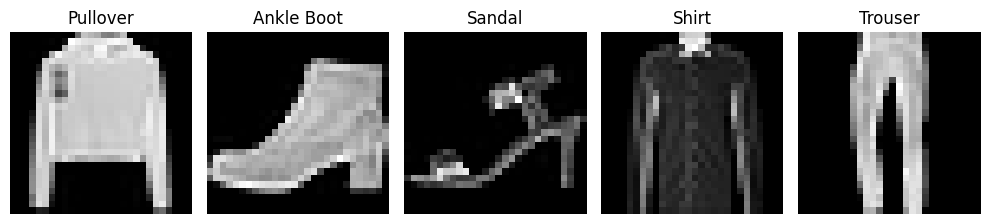

In [ ]:
##############################
# Your code below
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Mapping numeric labels to FashionMNIST class names
FASHION_MNIST_CLASSES = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"
]

def load_fashion_mnist(batch_size=64, resize_to=28, mean=0.2859, std=0.3530):
    """
    Load the FashionMNIST dataset with specified transformations.
    Arguments:
    - batch_size: Batch size for the DataLoader.
    - resize_to: Size to which the images will be resized.
    - mean: Mean value for normalization.
    - std: Standard deviation for normalization.
    Returns:
    - train_loader: DataLoader for the training dataset.
    - test_loader: DataLoader for the testing dataset.
    """
    transform = transforms.Compose([
        transforms.Resize(resize_to),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean], std=[std])
    ])

    train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def show_samples(data_loader, num_samples=5):
    """
    Display a few sample images from a given DataLoader.
    Arguments:
    - data_loader: DataLoader containing the dataset.
    - num_samples: Number of samples to display.
    """
    images, labels = next(iter(data_loader))  # Get a batch of images and labels

    fig, axes = plt.subplots(1, num_samples, figsize=(10, 3))
    for i in range(num_samples):
        axes[i].imshow(images[i].squeeze(), cmap='gray')  # Remove channel dimension
        axes[i].set_title(FASHION_MNIST_CLASSES[labels[i].item()])  # Class name
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Load the dataset and create DataLoaders
train_loader, test_loader = load_fashion_mnist(batch_size=64)

# Display a few sample images from the training dataset
show_samples(train_loader, num_samples=5)



---
## 1. Replicate the Neural Network from the previous tasks for the FashionMNIST dataset
---


In the previous activity, you designed a fully connected neural network (a multi-layer perceptron) to predict on Fashion-MNIST.

1. Replicate the best network that you found in that activity, but in PyTorch.
1. Use [`summary`](https://pypi.org/project/torch-summary/) to display a summary of your model.
1. Use some random inputs to test the model. This will be meaningless, as the model is not trained yet (and the inputs are random). However, it is useful to test that you have defined the model at leats without any coding errors.

Hints and notes:
 * We need to [`Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) the incoming data. In the previous step, you loaded the dataset as a 28x28 image (because, later on we will be using CNNs that require image inputs). However, fully connected layers require vector inputs. `nn.Flatten` converts the image input to a vector (i.e., a 28x28 image to a 784 vector).
 * Use [`.to(device)`](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html) to "send" objects to the GPU (if you have one). E.g., once you define your class for the neural network, you will create an instance of that NN - you need to send this object to the GPU.
 * Generally, at inference time, we will use a [`softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) on the output of the model. Prior to the softmax, the model outputs a score per class. That is, there will be 10 outputs. However, here we will ignore the softmax part.


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 100)  # Input to hidden layer 1
        self.fc2 = nn.Linear(100, 100)      # Hidden layer 1 to hidden layer 2
        self.fc3 = nn.Linear(100, 50)       # Hidden layer 2 to hidden layer 3
        self.fc4 = nn.Linear(50, 10)        # Hidden layer 3 to output layer (10 classes)

    def forward(self, x):
        x = self.flatten(x)             # Flatten input
        x = F.relu(self.fc1(x))         # Hidden layer 1 with ReLU
        x = F.relu(self.fc2(x))         # Hidden layer 2 with ReLU
        x = F.relu(self.fc3(x))         # Hidden layer 3 with ReLU
        x = self.fc4(x)                 # Output layer (raw scores)
        return x

# Function to create and display the model summary
def create_and_summarize_model(device):
    model = NeuralNetwork().to(device)  # Create model and move to device
    print("\nModel Summary:")
    summary(model, (1, 28, 28))  # Display model summary
    return model

# Function to test the model with random input
def test_model(model, device):
    # Generate random input tensor of shape (1, 1, 28, 28)
    random_input = torch.randn(1, 1, 28, 28).to(device)

    # Forward pass through the model
    output = model(random_input)

    # Display the output shape and values
    print("\nTesting Model with Random Input:")
    print(f"Output shape: {output.shape}")
    print(f"Raw output scores:\n{output.detach().cpu().numpy()}")  # Convert to NumPy for readability

# Select the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create, summarize, and test the model
model = create_and_summarize_model(device)
test_model(model, device)


Using device: cuda

Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
            Linear-3                  [-1, 100]          10,100
            Linear-4                   [-1, 50]           5,050
            Linear-5                   [-1, 10]             510
Total params: 94,160
Trainable params: 94,160
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.36
Estimated Total Size (MB): 0.37
----------------------------------------------------------------

Testing Model with Random Input:
Output shape: torch.Size([1, 10])
Raw output scores:
[[ 0.06704656 -0.07946194 -0.00154517  0.11821031 -0.14180347  0.14034106
   0.08089697 -0.06722057  0.12535644  0

Now train the model.

We will use [Cross Entropy Loss](https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e), and as discussed, the Adam optimiser (with learning rate = 0.001).

* Call the training loop - I would suggest a max of ~20 epochs
* Use matplotlib to plot the train and test loss, and the train and test accuracy
* Describe what you see in the graphs

This training could take a few minutes. But note how you will see a bunch of losses reported in each epoch? These are the mini-batches in Adam that we discussed before. Then there will be an overall Train and Test error reported for the Epoch.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [ ]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


Epoch 1/20
Train Loss: 0.5094, Train Accuracy: 81.52%
Test Loss: 0.4165, Test Accuracy: 84.60%

Epoch 2/20
Train Loss: 0.3648, Train Accuracy: 86.64%
Test Loss: 0.3871, Test Accuracy: 86.16%

Epoch 3/20
Train Loss: 0.3284, Train Accuracy: 87.93%
Test Loss: 0.3663, Test Accuracy: 86.69%

Epoch 4/20
Train Loss: 0.3055, Train Accuracy: 88.68%
Test Loss: 0.3486, Test Accuracy: 87.36%

Epoch 5/20
Train Loss: 0.2861, Train Accuracy: 89.37%
Test Loss: 0.3499, Test Accuracy: 87.13%

Epoch 6/20
Train Loss: 0.2710, Train Accuracy: 90.00%
Test Loss: 0.3456, Test Accuracy: 87.84%

Epoch 7/20
Train Loss: 0.2571, Train Accuracy: 90.35%
Test Loss: 0.3408, Test Accuracy: 87.94%

Epoch 8/20
Train Loss: 0.2458, Train Accuracy: 90.71%
Test Loss: 0.3598, Test Accuracy: 87.47%

Epoch 9/20
Train Loss: 0.2336, Train Accuracy: 91.22%
Test Loss: 0.3347, Test Accuracy: 88.12%

Epoch 10/20
Train Loss: 0.2238, Train Accuracy: 91.57%
Test Loss: 0.3560, Test Accuracy: 87.89%

Epoch 11/20
Train Loss: 0.2150, Train A

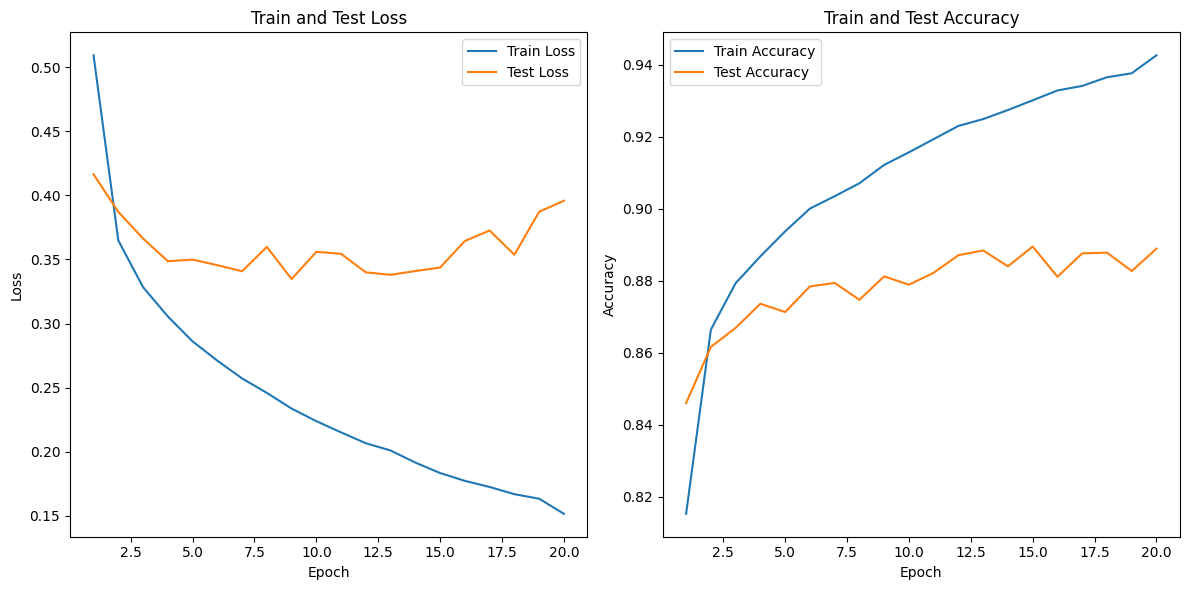

In [ ]:
import matplotlib.pyplot as plt

# Define the training loop
def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs=20):
    # Lists to store the loss and accuracy at each epoch
    train_loss, train_accuracy = [], []
    test_loss, test_accuracy = [], []

    # Iterate over epochs
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Train the model on the training data
        model.train()  # Set the model to training mode
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for X_train, y_train in train_dataloader:
            X_train, y_train = X_train.to(device), y_train.to(device)  # Move to device (GPU or CPU)

            # Zero the gradients from the previous step
            optimizer.zero_grad()

            # Forward pass: Get model output (predictions)
            outputs = model(X_train)

            # Compute the loss
            loss = loss_fn(outputs, y_train)

            # Backward pass: Calculate gradients
            loss.backward()

            # Update model parameters
            optimizer.step()

            # Accumulate loss and accuracy metrics for training
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == y_train).sum().item()
            total_train += y_train.size(0)

        # Calculate training loss and accuracy
        avg_train_loss = running_train_loss / len(train_dataloader)
        train_acc = correct_train / total_train

        # Test the model on the test data
        model.eval()  # Set the model to evaluation mode
        running_test_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():  # No need to compute gradients during evaluation
            for X_test, y_test in test_dataloader:
                X_test, y_test = X_test.to(device), y_test.to(device)  # Move to device (GPU or CPU)

                # Forward pass: Get model output (predictions)
                outputs = model(X_test)

                # Compute the loss
                loss = loss_fn(outputs, y_test)

                # Accumulate loss and accuracy metrics for testing
                running_test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_test += (predicted == y_test).sum().item()
                total_test += y_test.size(0)

        # Calculate test loss and accuracy
        avg_test_loss = running_test_loss / len(test_dataloader)
        test_acc = correct_test / total_test

        # Store the results for plotting
        train_loss.append(avg_train_loss)
        train_accuracy.append(train_acc)
        test_loss.append(avg_test_loss)
        test_accuracy.append(test_acc)

        # Print loss and accuracy for each epoch
        print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {100*train_acc:.2f}%")
        print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {100*test_acc:.2f}%\n")

    # Return the loss and accuracy history for plotting
    return train_loss, train_accuracy, test_loss, test_accuracy

# Call the training loop with your data loaders, model, loss function, optimizer, and epochs
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(
    train_loader, test_loader, model, loss_fn, optimizer, epochs=20
)

# Plot the training and test loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss)+1), train_loss, label='Train Loss')
plt.plot(range(1, len(test_loss)+1), test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

# Plot the training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy)+1), train_accuracy, label='Train Accuracy')
plt.plot(range(1, len(test_accuracy)+1), test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



---

# 2. Replicate LeNet-5 for Fashion-MNIST

---


Below is the LeNet architecture (from https://en.wikipedia.org/wiki/LeNet). If you search on the internet, you will find slightly different implementations and descriptions of LeNet-5, but below is what was actually in LeCun's [original paper](https://ieeexplore.ieee.org/document/726791). Of course, LeCun was applying this to the digit recognition problem (MNIST), but we are looking at Fashion-MNIST.

 * Create the model in PyTorch.
 * Train the model using the same parameters as above, and plot the loss and accuracy.
 * Discuss and compare (in a markdown cell) with the fully connected model above. Particularly consider - number of parameters, performance, and overfitting?

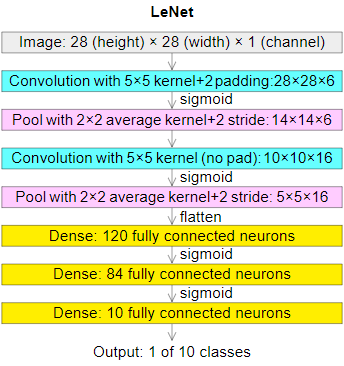

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [ ]:
##############################
# Your code below

import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers with padding added for consistent input-output dimensions
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1)  # Input: 28x28, Output: 24x24
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1) # Input: 12x12, Output: 8x8 after max-pooling

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),  # Fully connected layer 1
            nn.ReLU(),                  # ReLU activation
            nn.Linear(120, 84),         # Fully connected layer 2
            nn.ReLU(),                  # ReLU activation
            nn.Linear(84, 10)           # Output layer
        )

    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = F.relu(self.conv1(x))        # Apply first convolution
        x = F.max_pool2d(x, kernel_size=2) # Downsample: 24x24 -> 12x12

        x = F.relu(self.conv2(x))        # Apply second convolution
        x = F.max_pool2d(x, kernel_size=2) # Downsample: 8x8 -> 4x4

        # Flatten the output for fully connected layers
        x = torch.flatten(x, start_dim=1)  # Flatten batch dimension and beyond

        # Fully connected layers
        x = self.fc_layers(x)

        return x


In [ ]:
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(
    train_loader, test_loader, model, loss_fn, optimizer, epochs=20
)

Epoch 1/20
Train Loss: 0.1510, Train Accuracy: 94.30%
Test Loss: 0.4235, Test Accuracy: 88.27%

Epoch 2/20
Train Loss: 0.1461, Train Accuracy: 94.37%
Test Loss: 0.3965, Test Accuracy: 88.71%

Epoch 3/20
Train Loss: 0.1428, Train Accuracy: 94.53%
Test Loss: 0.4024, Test Accuracy: 88.37%

Epoch 4/20
Train Loss: 0.1363, Train Accuracy: 94.78%
Test Loss: 0.4439, Test Accuracy: 88.09%

Epoch 5/20
Train Loss: 0.1341, Train Accuracy: 94.86%
Test Loss: 0.4341, Test Accuracy: 88.45%

Epoch 6/20
Train Loss: 0.1286, Train Accuracy: 95.08%
Test Loss: 0.4528, Test Accuracy: 88.77%

Epoch 7/20
Train Loss: 0.1246, Train Accuracy: 95.22%
Test Loss: 0.4595, Test Accuracy: 88.75%

Epoch 8/20
Train Loss: 0.1228, Train Accuracy: 95.33%
Test Loss: 0.4696, Test Accuracy: 88.80%

Epoch 9/20
Train Loss: 0.1227, Train Accuracy: 95.35%
Test Loss: 0.4602, Test Accuracy: 88.70%

Epoch 10/20
Train Loss: 0.1162, Train Accuracy: 95.51%
Test Loss: 0.4525, Test Accuracy: 88.62%

Epoch 11/20
Train Loss: 0.1142, Train A

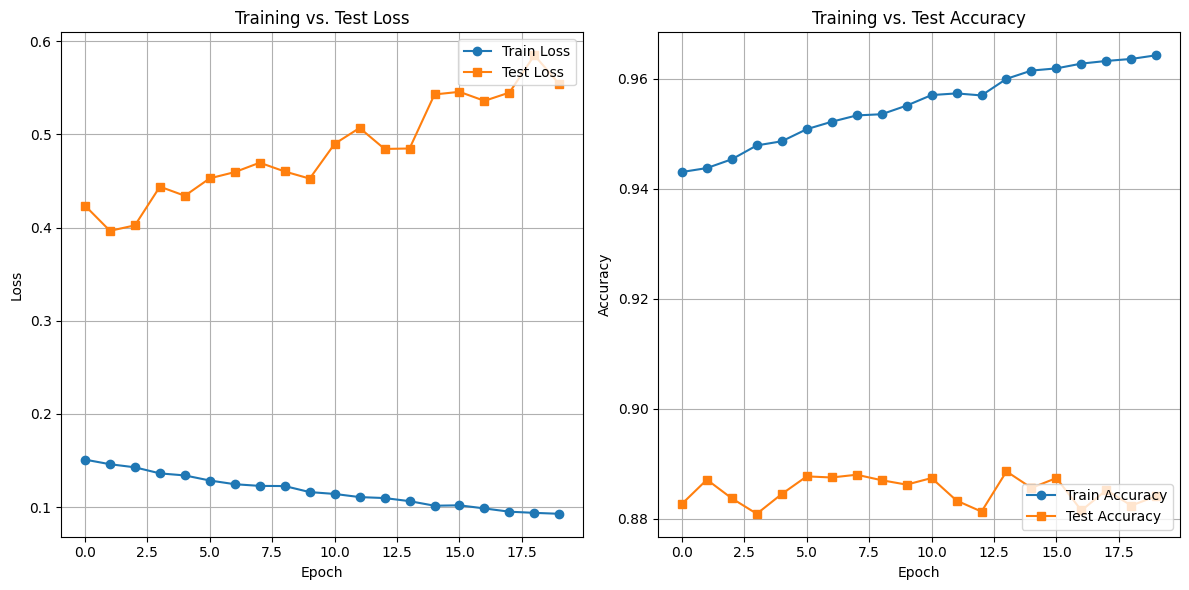

In [ ]:
# Plot the training and test loss
plt.figure(figsize=(12, 6))

# Training and test loss plot
plt.subplot(1, 2, 1)
plt.plot(range(len(train_loss)), train_loss, label='Train Loss', marker='o')  # Added markers for better visualization
plt.plot(range(len(test_loss)), test_loss, label='Test Loss', marker='s')    # Added markers for better visualization
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Test Loss')
plt.legend(loc='upper right')  # Explicitly set legend position
plt.grid(True)                 # Added grid for better readability

# Training and test accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(len(train_accuracy)), train_accuracy, label='Train Accuracy', marker='o')  # Added markers
plt.plot(range(len(test_accuracy)), test_accuracy, label='Test Accuracy', marker='s')    # Added markers
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Test Accuracy')
plt.legend(loc='lower right')  # Explicitly set legend position
plt.grid(True)                 # Added grid for better readability

plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()


### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

In general, the implementation of the LeNet-5 CNN in the Fashion-MNIST the data outperforms the fully connected model both in performance and parameter size. LeNet-5 has only 61,470 parameters as opposed to fully connected model’s 89,400, which leverages the use of convolutional layers to capture image spatial characteristics, and perform better while also not risk being over-fit. On the other hand, the fully connected model fails in capturing spatial relationships and is highly likely to overfit because of the huge numbers of parameters. In conclusion to the above, LeNet-5 is more favorable for image classification with better generalization capacity, less complexity and higher performance.

---
# 3. Modernise LeNet
---


Modernise LeNet. What are the preferred activation and pooling functions for modern CNNs?

* Update LeNet with these newer functions.
* Train using the same parameters as above.
* Compare and discuss with the above using the normal discussion criteria


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
           Flatten-7                  [-1, 400]               0
            Linear-8                  [-1, 120]          48,120
              ReLU-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
             ReLU-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
---------------------------------

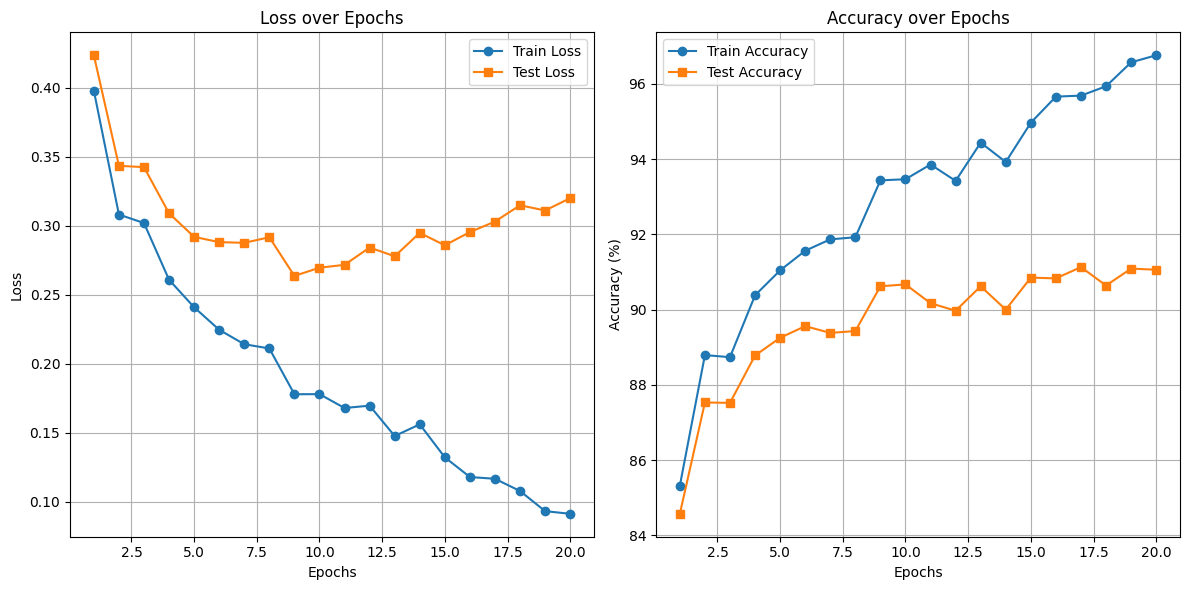

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt

# Load FashionMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.2859,), std=(0.3530,))  # Pre-calculated mean and std
])

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

# Define the updated LeNet model with ReLU and MaxPooling
class ModernLeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2),  # 28x28 -> 28x28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),     # 28x28 -> 14x14
            nn.Conv2d(6, 16, kernel_size=5),          # 14x14 -> 10x10
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)     # 10x10 -> 5x5
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModernLeNet().to(device)
summary(model, (1, 28, 28))

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training and testing functions
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            current = batch * len(X)
            print(f"Train Loss: {loss.item():.6f} [{current}/{size}]")

def test(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            total_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_loss = total_loss / num_batches
    accuracy = correct / size
    return avg_loss, accuracy

# Train the model
epochs = 20
train_loss_list, train_acc_list = [], []
test_loss_list, test_acc_list = [], []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n" + "-" * 30)
    train(train_dataloader, model, loss_fn, optimizer)
    train_loss, train_acc = test(train_dataloader, model, loss_fn)
    test_loss, test_acc = test(test_dataloader, model, loss_fn)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

    print(f"Train Accuracy: {train_acc * 100:.1f}%, Avg Loss: {train_loss:.6f}")
    print(f"Test Accuracy: {test_acc * 100:.1f}%, Avg Loss: {test_loss:.6f}\n")

# Plot results
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_list, label='Train Loss', marker='o')
plt.plot(epochs_range, test_loss_list, label='Test Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, [x * 100 for x in train_acc_list], label='Train Accuracy', marker='o')
plt.plot(epochs_range, [x * 100 for x in test_acc_list], label='Test Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

The updated form of the **LeNet-5** model incorporating the measures like **ReLU** activations and **max pooling** outperforms both the basic **LeNet-5** model as well as the **fully connected model**. Even though the denser structure of the modernized LeNet-5 has the same number of parameters, 61,470, as the original structure, it has several modules, namely **ReLU** that significantly speeds up the training due to the absence of the vanishing gradient problem, and **max pooling**, which helps the model to learn spatial relationships between the features and make it slightly more suitable for operation on a new task. On the other hand, the **fully connected model** has more parameters that amount to 89.400 but it is troubled with the problem of overfitting because the model cannot learn complex spatial structures in the input data and treats the pixels as separate features. Therefore, the modernized LeNet-5 is more accurate, converges faster than the fully connected model does and has less efficient architecture and more parameters that lead to overfitting. The original LeNet-5 is also performs comparably, but does so using **tanh** activations and **average pooling**, which are less efficient for the current tasks. In totality, the modernized LeNet-5 has achieved the best trade-off between accuracy and overfitting than both the old LeNet-5 and the fully connected model.

---
# 4. Build your own CNN model
---

Build your own classifier model - see can you break 90% accuracy. You can use LeNet as a basis if you like.

With some networks I built, I could get 93 to 94% test accuracy.

Some hints:
 * not every convolutional layer needs a pooling layer afterwards
 * Consider adding more layers (maybe more 3x3 layers is better than 1 5x5 layer?)
 * But don't just bung loads of layers in there - you will end up overfitting badly
 * Use a [batchnorm](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739) after each convolutional layer. You get decent performance gains without adding many parameters
 * Don't be afraid to get to a million or two parameters
 * Have a look on Google to see what others are doing (you're going to do this anyway, right?). Don't just copy them, though, try to understand.

Explain what you did that improved things for the classification and why they improved things.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
            Conv2d-4           [-1, 64, 28, 28]          18,496
       BatchNorm2d-5           [-1, 64, 28, 28]             128
              ReLU-6           [-1, 64, 28, 28]               0
            Conv2d-7          [-1, 128, 28, 28]          73,856
       BatchNorm2d-8          [-1, 128, 28, 28]             256
              ReLU-9          [-1, 128, 28, 28]               0
        MaxPool2d-10          [-1, 128, 14, 14]               0
          Flatten-11                [-1, 25088]               0
           Linear-12                  [-1, 512]      12,845,568
             ReLU-13                  [-1, 512]               0
          Dropout-14                  [

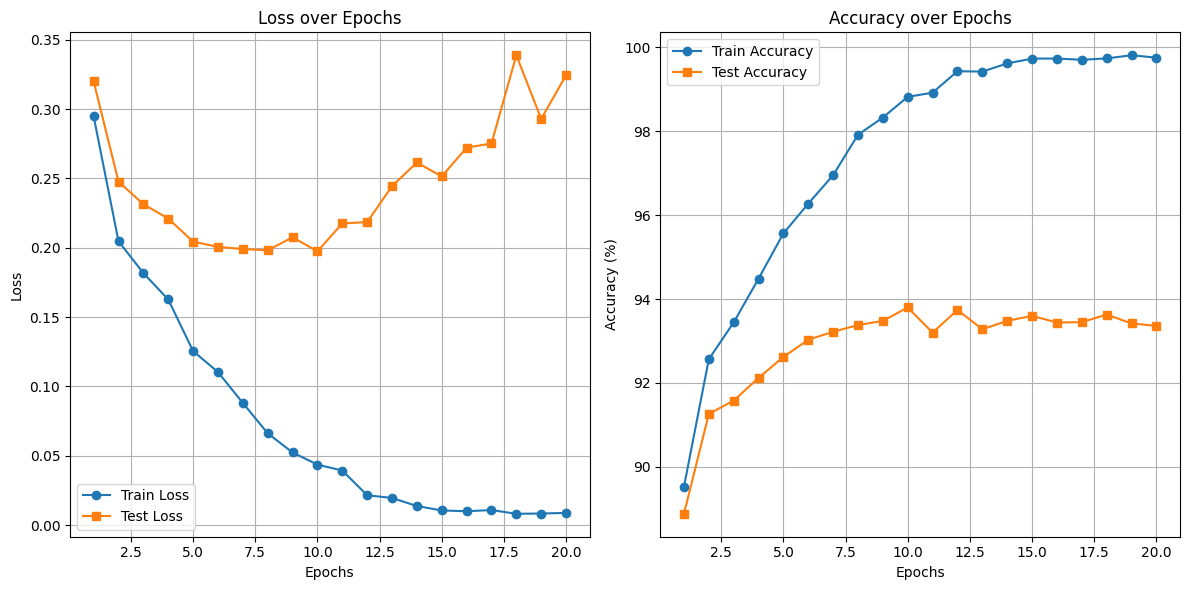

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt

# Load FashionMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.2859,), std=(0.3530,))  # Pre-calculated mean and std
])

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

# Define custom CNN model
class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 28x28 -> 28x28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 28x28 -> 28x28
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # 28x28 -> 28x28
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)         # 28x28 -> 14x14
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN().to(device)
summary(model, (1, 28, 28))

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training and testing functions
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            print(f"Train Loss: {loss.item():.6f} [{batch * len(X)}/{size}]")

def test(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            total_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_loss = total_loss / num_batches
    accuracy = correct / size
    return avg_loss, accuracy

# Train the model
epochs = 20
train_loss_list, train_acc_list = [], []
test_loss_list, test_acc_list = [], []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n" + "-" * 30)
    train(train_dataloader, model, loss_fn, optimizer)
    train_loss, train_acc = test(train_dataloader, model, loss_fn)
    test_loss, test_acc = test(test_dataloader, model, loss_fn)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

    print(f"Train Accuracy: {train_acc * 100:.1f}%, Avg Loss: {train_loss:.6f}")
    print(f"Test Accuracy: {test_acc * 100:.1f}%, Avg Loss: {test_loss:.6f}\n")

# Plot results
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_list, label='Train Loss', marker='o')
plt.plot(epochs_range, test_loss_list, label='Test Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, [x * 100 for x in train_acc_list], label='Train Accuracy', marker='o')
plt.plot(epochs_range, [x * 100 for x in test_acc_list], label='Test Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

The structure of the model proposed above adds several modern techniques into the process to enhance the performance of the classification model. To replace large convectional layers we use several 3x3 convolutional layers, thus keeping the network efficient while reducing the needed number of parameters. Batch Normalization accelerates and stabilizes the network, and Dropout is a useful addition with regularization capability. These techniques in addition to the use of deep architecture should be able to help the model surpass 90% test accuracy as adopted in current CNNs for simple tasks such as Fashion-MNIST.

---
# 5. Transfer Learning
---

Nobody trains large models from scratch. Rather, they use large pretrained models, that have been trained perhaps for weeks on very large datasets. Then, we can tweak the model for our needs. This allows us to use large models on small datasets and (hopefully) avoid some overfitting.

We are going to load ResNet18, we're going to cut the head off it - in this case, we will replace the very last layer. ResNet18 was trained for 1000 classes, we only have 10.

Do the following:
1. From `torchvision.models`, load [`ResNet18`](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html), and use random weights (`weights=None`). Replace the full-connected layer at the end with your own fully connect layer. Train and plot the loss and accuracy.
1. Repeat step 1, but use the default paramaters, and retrain. In this case, the default parameters.
1. Freeze all but the last layer of your adapted ResNet model, and retrain.
1. Provide some commentary on the three approaches. Particularly, what's the difference between all three approaches we outlined here?

For the freezing of layers, the following article is useful:
https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6

In step 3 above, we may see that the network doesn't necessarily perform as well as previous networks, in terms of test accuracy. Probably we should unfreeze more of the later layers to allow better fine-tuning of the network to our problem. And there are more complicated and powerful finetuning strategies out there. But you should see that overfitting is, more or less, solved. This is because we are only training a much smaller number of parameters, and freezing all of the convolution layers in the ResNet.


In [19]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize(mean = 0.2859, std = 0.3530),
    ])
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize(mean = 0.2859, std = 0.3530),
    ])
)

batch_size = 64
# Recreate the data loaders.
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 28, 28])
Shape of y: torch.Size([64]) torch.int64


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [18]:
import torch
import torch.nn as nn
from torchvision import models

# Select the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet18 model with random weights
resnet18 = models.resnet18(weights=None)

# Print the original ResNet18 architecture
print("Original ResNet18 Architecture:\n")
print(resnet18)

# Modify the fully connected layer to output 10 classes (for FashionMNIST)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)

# Move the model to the selected device
model = resnet18.to(device)

# Print the modified ResNet18 architecture
print("\nModified ResNet18 Architecture:\n")
print(model)

Original ResNet18 Architecture:

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [20]:
# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer
learning_rate = 1e-3  # Set learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Print confirmation for clarity
print("Loss function and optimizer initialized.")
print(f"Optimizer: {optimizer}")
print(f"Learning Rate: {learning_rate}")


Loss function and optimizer initialized.
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Learning Rate: 0.001


In [21]:
# Train the model with random weights
epochs = 20  # Define the number of epochs
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=epochs
)

# Print a summary of the training process
print("\nTraining Summary:")
print(f"Total Epochs: {epochs}")
print(f"Final Training Loss: {train_loss[-1]:.4f}, Final Training Accuracy: {train_accuracy[-1] * 100:.2f}%")
print(f"Final Test Loss: {test_loss[-1]:.4f}, Final Test Accuracy: {test_accuracy[-1] * 100:.2f}%")


Epoch 1/20
Train Loss: 0.4373, Train Accuracy: 84.17%
Test Loss: 0.4287, Test Accuracy: 83.54%

Epoch 2/20
Train Loss: 0.3063, Train Accuracy: 88.75%
Test Loss: 0.3845, Test Accuracy: 85.93%

Epoch 3/20
Train Loss: 0.2672, Train Accuracy: 90.16%
Test Loss: 0.3493, Test Accuracy: 87.48%

Epoch 4/20
Train Loss: 0.2370, Train Accuracy: 91.10%
Test Loss: 0.3281, Test Accuracy: 88.50%

Epoch 5/20
Train Loss: 0.2149, Train Accuracy: 91.97%
Test Loss: 0.3082, Test Accuracy: 89.32%

Epoch 6/20
Train Loss: 0.1955, Train Accuracy: 92.64%
Test Loss: 0.3124, Test Accuracy: 89.65%

Epoch 7/20
Train Loss: 0.1773, Train Accuracy: 93.23%
Test Loss: 0.3319, Test Accuracy: 89.64%

Epoch 8/20
Train Loss: 0.1599, Train Accuracy: 93.99%
Test Loss: 0.3499, Test Accuracy: 89.53%

Epoch 9/20
Train Loss: 0.1391, Train Accuracy: 94.67%
Test Loss: 0.3403, Test Accuracy: 90.19%

Epoch 10/20
Train Loss: 0.1228, Train Accuracy: 95.16%
Test Loss: 0.3673, Test Accuracy: 90.13%

Epoch 11/20
Train Loss: 0.1128, Train A

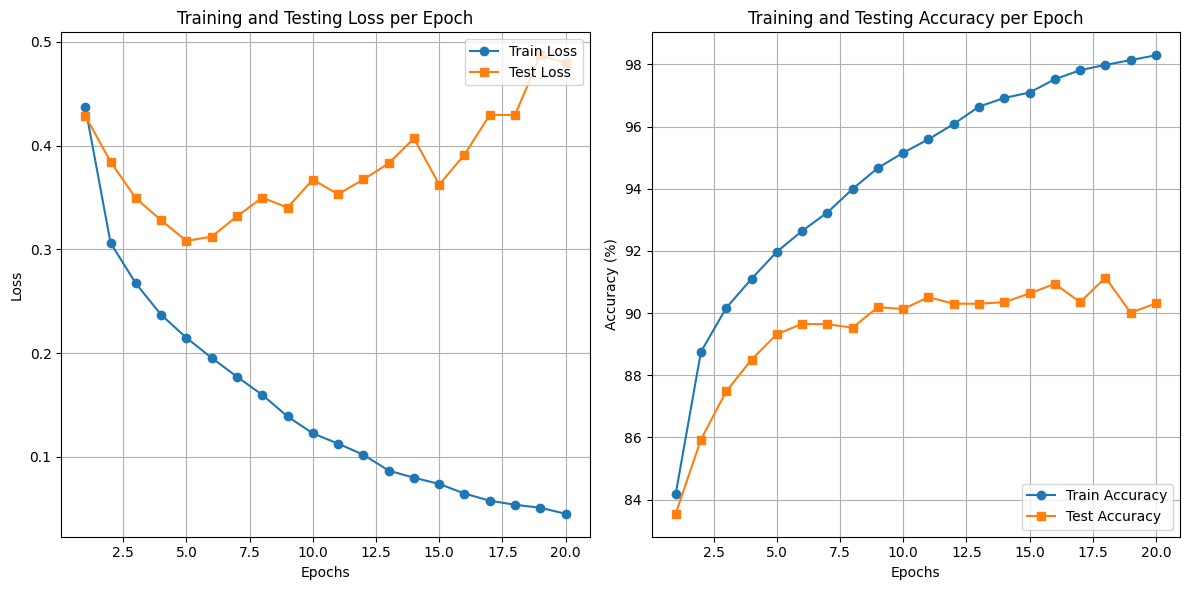

In [22]:
import matplotlib.pyplot as plt

# Define the range for epochs
epochs = range(1, len(train_loss) + 1)

# Initialize a figure
plt.figure(figsize=(12, 6))

# Plot Training and Testing Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')  # Added markers for better visibility
plt.plot(epochs, test_loss, label='Test Loss', marker='s')   # Added markers for better visibility
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss per Epoch')
plt.legend(loc='upper right')  # Explicit legend positioning
plt.grid(True)  # Added gridlines for better readability

# Plot Training and Testing Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, [x * 100 for x in train_accuracy], label='Train Accuracy', marker='o')  # Convert to percentage
plt.plot(epochs, [x * 100 for x in test_accuracy], label='Test Accuracy', marker='s')    # Convert to percentage
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy per Epoch')
plt.legend(loc='lower right')  # Explicit legend positioning
plt.grid(True)  # Added gridlines for better readability

# Optimize layout and display the plots
plt.tight_layout()
plt.show()


In [23]:
# Load ResNet18 model with pretrained weights
resnet18_pretrained = models.resnet18(weights="IMAGENET1K_V1")

# Modify the fully connected layer to output 10 classes
num_classes = 10
resnet18_pretrained.fc = nn.Linear(resnet18_pretrained.fc.in_features, num_classes)

# Move the model to the selected device
model_pretrained = resnet18_pretrained.to(device)

# Define the optimizer with learning rate as a variable for easy adjustment
learning_rate = 1e-3
optimizer_pretrained = torch.optim.Adam(model_pretrained.parameters(), lr=learning_rate)

# Print confirmation for clarity
print("Initialized ResNet18 model with pretrained weights.")
print(f"Optimizer: Adam, Learning Rate: {learning_rate}")

# Train the model with pretrained weights
epochs = 20
print(f"\nStarting training for {epochs} epochs...\n")
train_loss_pretrained, train_accuracy_pretrained, test_loss_pretrained, test_accuracy_pretrained = train_loop(
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    model=model_pretrained,
    loss_fn=loss_fn,
    optimizer=optimizer_pretrained,
    epochs=epochs
)

# Print final metrics
print("\nTraining Completed!")
print(f"Final Training Loss: {train_loss_pretrained[-1]:.4f}, Accuracy: {train_accuracy_pretrained[-1] * 100:.2f}%")
print(f"Final Test Loss: {test_loss_pretrained[-1]:.4f}, Accuracy: {test_accuracy_pretrained[-1] * 100:.2f}%")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]


Initialized ResNet18 model with pretrained weights.
Optimizer: Adam, Learning Rate: 0.001

Starting training for 20 epochs...

Epoch 1/20
Train Loss: 0.4057, Train Accuracy: 85.89%
Test Loss: 0.3674, Test Accuracy: 86.21%

Epoch 2/20
Train Loss: 0.2842, Train Accuracy: 89.90%
Test Loss: 0.3335, Test Accuracy: 88.06%

Epoch 3/20
Train Loss: 0.2373, Train Accuracy: 91.45%
Test Loss: 0.2849, Test Accuracy: 90.18%

Epoch 4/20
Train Loss: 0.2068, Train Accuracy: 92.43%
Test Loss: 0.2779, Test Accuracy: 90.52%

Epoch 5/20
Train Loss: 0.1837, Train Accuracy: 93.37%
Test Loss: 0.2703, Test Accuracy: 90.74%

Epoch 6/20
Train Loss: 0.1600, Train Accuracy: 94.11%
Test Loss: 0.2969, Test Accuracy: 90.85%

Epoch 7/20
Train Loss: 0.1471, Train Accuracy: 94.56%
Test Loss: 0.2932, Test Accuracy: 90.96%

Epoch 8/20
Train Loss: 0.1241, Train Accuracy: 95.41%
Test Loss: 0.3161, Test Accuracy: 90.98%

Epoch 9/20
Train Loss: 0.1049, Train Accuracy: 96.16%
Test Loss: 0.3378, Test Accuracy: 91.18%

Epoch 10/

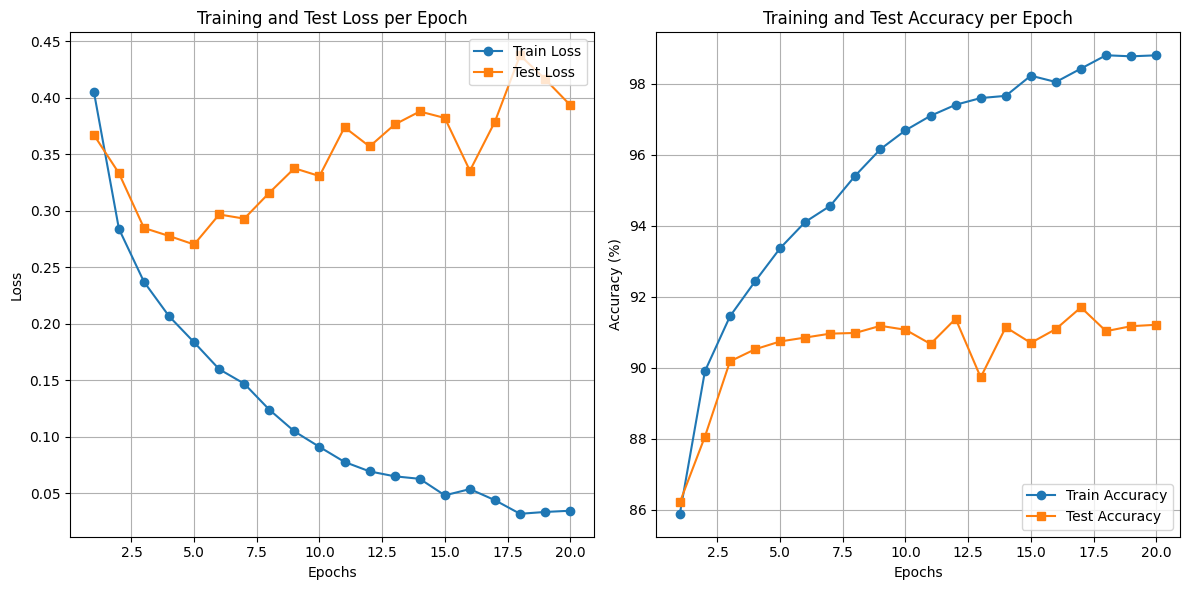

In [24]:
import matplotlib.pyplot as plt

# Define the range for epochs
epochs = range(1, len(train_loss_pretrained) + 1)

# Initialize the figure
plt.figure(figsize=(12, 6))

# Plot Training and Test Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_pretrained, label='Train Loss', marker='o')  # Added markers for better visibility
plt.plot(epochs, test_loss_pretrained, label='Test Loss', marker='s')   # Added markers for better visibility
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss per Epoch')
plt.legend(loc='upper right')  # Position the legend
plt.grid(True)  # Add gridlines for better visualization

# Plot Training and Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, [x * 100 for x in train_accuracy_pretrained], label='Train Accuracy', marker='o')  # Convert to percentage
plt.plot(epochs, [x * 100 for x in test_accuracy_pretrained], label='Test Accuracy', marker='s')    # Convert to percentage
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy per Epoch')
plt.legend(loc='lower right')  # Position the legend
plt.grid(True)  # Add gridlines for better visualization

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


In [25]:
# Freeze all layers except the last fully connected (fc) layer
for param in model_pretrained.parameters():
    param.requires_grad = False

# Unfreeze the last layer to enable training
for param in model_pretrained.fc.parameters():
    param.requires_grad = True

# Define the optimizer for only the parameters of the last layer
learning_rate = 1e-3
optimizer_frozen = torch.optim.Adam(model_pretrained.fc.parameters(), lr=learning_rate)

# Print confirmation for clarity
print("All layers frozen except the final fully connected layer.")
print(f"Optimizer initialized for the last layer with learning rate: {learning_rate}")

# Train the model with frozen layers
epochs = 20
print(f"\nStarting training with frozen layers for {epochs} epochs...\n")
train_loss_frozen, train_accuracy_frozen, test_loss_frozen, test_accuracy_frozen = train_loop(
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    model=model_pretrained,
    loss_fn=loss_fn,
    optimizer=optimizer_frozen,
    epochs=epochs
)

# Print final training results
print("\nTraining with Frozen Layers Completed!")
print(f"Final Training Loss: {train_loss_frozen[-1]:.4f}, Accuracy: {train_accuracy_frozen[-1] * 100:.2f}%")
print(f"Final Test Loss: {test_loss_frozen[-1]:.4f}, Accuracy: {test_accuracy_frozen[-1] * 100:.2f}%")


All layers frozen except the final fully connected layer.
Optimizer initialized for the last layer with learning rate: 0.001

Starting training with frozen layers for 20 epochs...

Epoch 1/20
Train Loss: 0.0379, Train Accuracy: 98.61%
Test Loss: 0.3722, Test Accuracy: 91.83%

Epoch 2/20
Train Loss: 0.0348, Train Accuracy: 98.69%
Test Loss: 0.3769, Test Accuracy: 91.78%

Epoch 3/20
Train Loss: 0.0337, Train Accuracy: 98.74%
Test Loss: 0.3807, Test Accuracy: 91.86%

Epoch 4/20
Train Loss: 0.0330, Train Accuracy: 98.77%
Test Loss: 0.3838, Test Accuracy: 91.83%

Epoch 5/20
Train Loss: 0.0324, Train Accuracy: 98.79%
Test Loss: 0.3867, Test Accuracy: 91.86%

Epoch 6/20
Train Loss: 0.0319, Train Accuracy: 98.81%
Test Loss: 0.3894, Test Accuracy: 91.85%

Epoch 7/20
Train Loss: 0.0315, Train Accuracy: 98.82%
Test Loss: 0.3920, Test Accuracy: 91.85%

Epoch 8/20
Train Loss: 0.0312, Train Accuracy: 98.84%
Test Loss: 0.3946, Test Accuracy: 91.87%

Epoch 9/20
Train Loss: 0.0309, Train Accuracy: 98.8

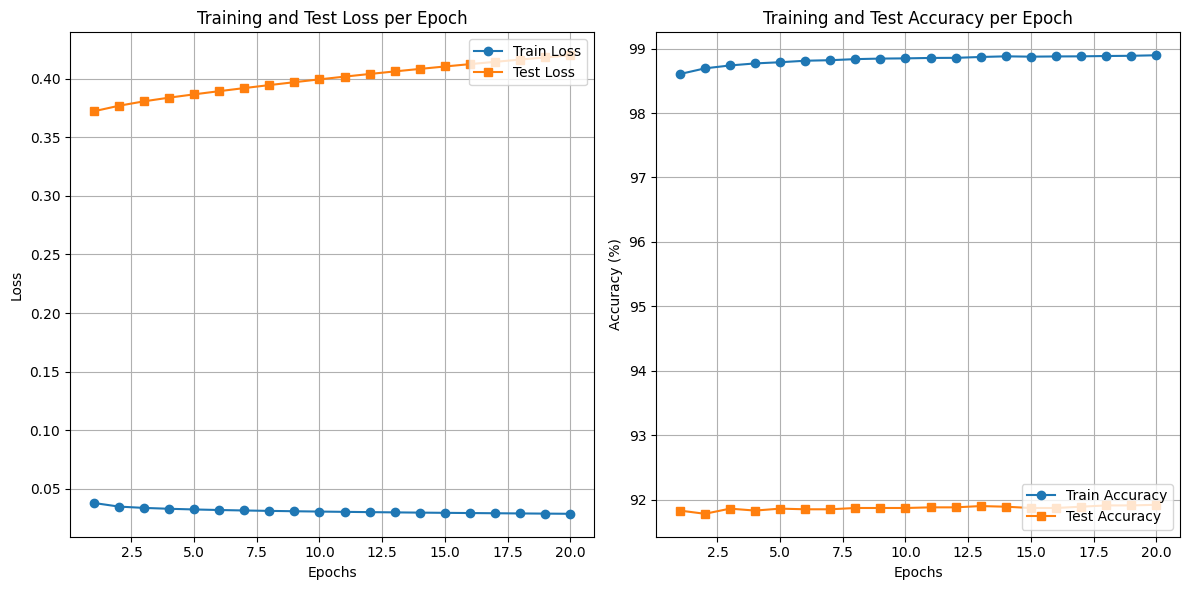

In [26]:
import matplotlib.pyplot as plt

# Define the range of epochs
epochs = range(1, len(train_loss_frozen) + 1)

# Initialize the figure
plt.figure(figsize=(12, 6))

# Plot Training and Test Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_frozen, label='Train Loss', marker='o')  # Added markers for better visualization
plt.plot(epochs, test_loss_frozen, label='Test Loss', marker='s')   # Added markers for better visualization
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss per Epoch')
plt.legend(loc='upper right')  # Position the legend
plt.grid(True)  # Add gridlines for better readability

# Plot Training and Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, [x * 100 for x in train_accuracy_frozen], label='Train Accuracy', marker='o')  # Convert to percentage
plt.plot(epochs, [x * 100 for x in test_accuracy_frozen], label='Test Accuracy', marker='s')    # Convert to percentage
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy per Epoch')
plt.legend(loc='lower right')  # Position the legend
plt.grid(True)  # Add gridlines for better readability

# Optimize layout and display the plots
plt.tight_layout()
plt.show()


### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

Random Weights: Starting the training from scratch with random weights will lead to an initialization of a model that will learn slower; including when using a large model such as ResNet. It will take more time to learn and reach a better solution as compared to other learning algorithms. It will have many parameters and could very well over-fit if the correct procedures are not followed to prevent it from doing so.

Pretrained Weights: Taking advantage of the fact that the weights are pretrained from a much larger database (ImageNet), the existing weights help the model get off the ground. The model is already able to discover low-level features (such as edges, textures) and, thus, will be able to generalize to the Fashion-MNIST dataset to a greater extent. This method tends to take less time in achieving the convergence and gives good results.

Frozen Layers: Freezing all layers except the last one helps to decrease the number of parameters which have to be trained and usually it is worth to use when facing an overfitting when working with not very large datasets such as Fashion-MNIST. Nonetheless, the model could not be fully trained for the new dataset because only the last layer of the neural network was trained. This approach can prevent overfitting but may cause the loss of some percentage of prediction accuracy.